In [1]:
import warnings
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sqlalchemy import create_engine
import sqlite3

warnings.filterwarnings("ignore")

In [2]:
# Opens the JSON files and loads them into pandas DataFrames
with open("data/Streaming_History_Audio_2021-2024_0.json", encoding="utf-8") as a:
    a_data = json.load(a)

with open("data/Streaming_History_Audio_2024-2025_1.json", encoding="utf-8") as b:
    b_data = json.load(b)

with open("data/Streaming_History_Audio_2025_2.json", encoding="utf-8") as c:
    c_data = json.load(c)
    
a_data = pd.json_normalize(a_data)
b_data = pd.json_normalize(b_data) # Normalize the JSON data into a flat table
c_data = pd.json_normalize(c_data)

df = pd.concat([a_data, b_data, c_data], ignore_index=True) # Combines the DataFrames into one
print(df.columns)
df.head()

Index(['ts', 'platform', 'ms_played', 'conn_country', 'ip_addr',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'audiobook_title',
       'audiobook_uri', 'audiobook_chapter_uri', 'audiobook_chapter_title',
       'reason_start', 'reason_end', 'shuffle', 'skipped', 'offline',
       'offline_timestamp', 'incognito_mode'],
      dtype='object')


,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2021-12-13T14:29:52Z,Windows 10 (10.0.19043; x64),198053,PH,110.54.197.174,The Feels,TWICE,Formula of Love: O+T=<3,spotify:track:308Ir17KlNdlrbVLHWhlLe,None,...,None,None,None,playbtn,trackdone,False,False,False,NaN,False
1,2021-12-13T14:33:07Z,Windows 10 (10.0.19043; x64),194600,PH,110.54.197.174,SCIENTIST,TWICE,Formula of Love: O+T=<3,spotify:track:0BJMgVrnWIvgYsjq8KaPeh,None,...,None,None,None,trackdone,trackdone,False,False,False,NaN,False
2,2021-12-13T14:36:39Z,Windows 10 (10.0.19043; x64),210573,PH,110.54.197.174,Alcohol-Free,TWICE,Taste of Love,spotify:track:0BTaaKT4RMbs5M73tOHX5Y,None,...,None,None,None,trackdone,trackdone,False,False,False,NaN,False
3,2021-12-13T14:40:04Z,Windows 10 (10.0.19043; x64),205493,PH,110.54.197.174,I CAN'T STOP ME,TWICE,Eyes Wide Open,spotify:track:37ZtpRBkHcaq6hHy0X98zn,None,...,None,None,None,trackdone,trackdone,False,False,False,NaN,False
4,2021-12-13T14:44:04Z,Windows 10 (10.0.19043; x64),208240,PH,110.54.197.174,What is Love,TWICE,Summer Nights,spotify:track:3zhbXKFjUDw40pTYyCgt1Y,None,...,None,None,None,trackdone,trackdone,False,False,False,NaN,False


In [3]:
df["ts"] = pd.to_datetime(df["ts"], format="ISO8601", utc=True) # Converts the 'ts' column to datetime format
df["ts"] = df["ts"].dt.tz_convert("Asia/Manila") # Converts the timezone to Asia/Manila

cleaned_df = df[["ts", "master_metadata_track_name", "master_metadata_album_artist_name", "master_metadata_album_album_name", "reason_start", "reason_end", "skipped"]]
cleaned_df.columns = ["time", "song", "artist", "album", "start_reason", "end_reason", "skipped"]

cleaned_df = cleaned_df.dropna().reset_index() # Drops rows with any NaN values
cleaned_df.head(10)

,index,time,song,artist,album,start_reason,end_reason,skipped
0,0,2021-12-13 22:29:52+08:00,The Feels,TWICE,Formula of Love: O+T=<3,playbtn,trackdone,False
1,1,2021-12-13 22:33:07+08:00,SCIENTIST,TWICE,Formula of Love: O+T=<3,trackdone,trackdone,False
2,2,2021-12-13 22:36:39+08:00,Alcohol-Free,TWICE,Taste of Love,trackdone,trackdone,False
3,3,2021-12-13 22:40:04+08:00,I CAN'T STOP ME,TWICE,Eyes Wide Open,trackdone,trackdone,False
4,4,2021-12-13 22:44:04+08:00,What is Love,TWICE,Summer Nights,trackdone,trackdone,False
5,5,2021-12-13 22:47:38+08:00,FANCY,TWICE,FANCY YOU,trackdone,trackdone,False
6,6,2021-12-13 22:51:06+08:00,Feel Special,TWICE,Feel Special,trackdone,trackdone,False
7,7,2021-12-13 22:54:30+08:00,CRY FOR ME,TWICE,CRY FOR ME,trackdone,trackdone,False
8,8,2021-12-13 22:57:57+08:00,ICON,TWICE,Formula of Love: O+T=<3,trackdone,trackdone,False
9,9,2021-12-13 23:04:25+08:00,MOONLIGHT,TWICE,Formula of Love: O+T=<3,trackdone,trackdone,False


In [4]:
top_artists = cleaned_df["artist"].value_counts().head(10) # Gets the top 10 artists
top_artists = top_artists.reset_index() # Resets the index for better readability
print("Top 10 Artists:\n", top_artists)

Top 10 Artists:
           artist  count
0     Cup of Joe   1675
1          TWICE   1585
2   Zack Tabudlo    907
3        Ben&Ben    904
4    The Ridleys    768
5            WWE    674
6           mrld    643
7           BUZZ    594
8  Martti Franca    586
9           BINI    574


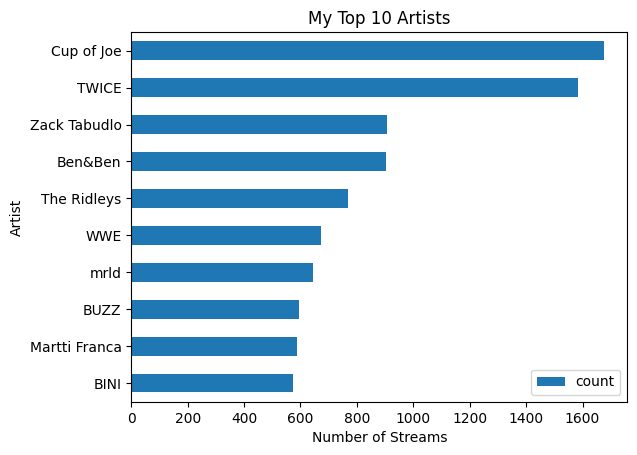

In [5]:
# Plots the top 10 artists using Matplotlib
top_artists.sort_values(by="count", ascending=True).plot(kind="barh", x="artist", y="count")
plt.title("My Top 10 Artists")
plt.xlabel("Number of Streams")
plt.ylabel("Artist")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    top_artists,
    x=top_artists["count"].sort_values(ascending=True),
    y=top_artists["artist"].sort_index(ascending=False),
    title="My Top 10 Artists",
    labels={"x" : "Artist", "y" : "Number of Streams"},
    orientation="h"
)

fig.show()

In [6]:
top_albums = cleaned_df["album"].value_counts()
top_albums = top_albums.reset_index()

# Get the artist for each album in top_albums
album_to_artist = cleaned_df.drop_duplicates(subset=["album"])[["artist", "album"]].set_index("album")["artist"]
top_albums["artist"] = top_albums["album"].map(album_to_artist)
top_albums = top_albums[["artist", "album", "count"]]
print("Top 10 Albums:\n", top_albums.head(10))

Top 10 Albums:
            artist                              album  count
0            Hale                               Hale    349
1     The Ridleys  Reflections on Moonlight & Poetry    301
2    Zack Tabudlo                 3rd Time’s A Charm    287
3      Cup of Joe                        Estranghero    272
4      Cup of Joe                       Patutunguhan    260
5    Zack Tabudlo                            Episode    260
6           TWICE                        BETWEEN 1&2    208
7      Bruno Mars               Doo-Wops & Hooligans    207
8  Unique Salonga                            Grandma    200
9    IV Of Spades                      CLAPCLAPCLAP!    198


In [7]:
top_songs = cleaned_df["song"].value_counts()
top_songs = top_songs.reset_index()

song_to_artist = cleaned_df.drop_duplicates(subset=["song"])[["artist", "song"]].set_index("song")["artist"]
top_songs["artist"] = top_songs["song"].map(song_to_artist)
top_songs = top_songs[["artist", "song", "count"]]
print("Top 10 Songs:\n", top_songs.head(10))

Top 10 Songs:
            artist                      song  count
0      Cup of Joe               Estranghero    272
1      Cup of Joe                Misteryoso    197
2      Cup of Joe                    Tingin    196
3  Up Dharma Down                   Tadhana    191
4      Cup of Joe                 Sinderela    176
5      Lola Amour                    Fallen    168
6            Maki                     Dilaw    167
7      Cup of Joe               Wag Na Lang    167
8            mrld               Ikaw Pa Rin    165
9   Martti Franca  Things She'll Never Know    163


In [8]:
skipped_songs = cleaned_df[cleaned_df["skipped"] == True]
skipped_song_counts = skipped_songs["song"].value_counts().head(10) # Gets the top 10 skipped songs
skipped_song_counts = skipped_song_counts.reset_index()

song_to_artist = skipped_songs.drop_duplicates(subset=["song"])[["artist", "song"]].set_index("song")["artist"]
skipped_song_counts["artist"] = skipped_song_counts["song"].map(song_to_artist)
skipped_song_counts = skipped_song_counts[["artist", "song", "count"]]

print("Top 10 Skipped Songs:\n", skipped_song_counts.head(10))

Top 10 Skipped Songs:
              artist         song  count
0              Maki        Dilaw     77
1        Cup of Joe  Estranghero     70
2        Cup of Joe   Misteryoso     62
3        Cup of Joe       Tingin     62
4        Lola Amour       Fallen     51
5        Cup of Joe  Wag Na Lang     51
6  Healy After Dark         Isip     47
7    Up Dharma Down      Tadhana     46
8            NOBITA    Ikaw Lang     44
9              MKTO      Classic     43


In [9]:
cleaned_df_copy = cleaned_df.copy() # Creates a copy of the cleaned DataFrame for further analysis

In [ ]:
# Creates a DataFrame with unique artists and assigns a unique ID to each artist
streamed_artists = pd.DataFrame(cleaned_df_copy["artist"].unique(), columns=["artist"]) # Creates a DataFrame with unique artists
streamed_artists["artist_id"] = streamed_artists.index + 1 # Assigns a unique ID to each artist
streamed_artists = streamed_artists.iloc[:, [1, 0]] # Reorders the columns to have artist_id first
streamed_artists.head(10)

,artist_id,artist
0,1,TWICE
1,2,NiziU
2,3,J.Y. Park
3,4,(G)I-DLE
4,5,Stray Kids
5,6,GOT7
6,7,STAYC
7,8,K/DA
8,9,Seungmin
9,10,ITZY


In [ ]:
# Creates a DataFrame with unique songs and assigns a unique ID to each song
streamed_music = pd.DataFrame(cleaned_df_copy["song"].unique(), columns=["song"]) # Creates a DataFrame with unique songs
streamed_music["song_id"] = streamed_music.index + 1 # Assigns a unique
streamed_music = streamed_music.iloc[:, [1, 0]] # Reorders the columns to have song_id first
streamed_music.head(10)

,song_id,song
0,1,The Feels
1,2,SCIENTIST
2,3,Alcohol-Free
3,4,I CAN'T STOP ME
4,5,What is Love
5,6,FANCY
6,7,Feel Special
7,8,CRY FOR ME
8,9,ICON
9,10,MOONLIGHT


In [ ]:
# Creates a DataFrame with unique albums and assigns a unique ID to each album
streamed_albums = pd.DataFrame(cleaned_df_copy["album"].unique(), columns=["album"]) # Creates a DataFrame with unique albums
streamed_albums["album_id"] = streamed_albums.index + 1 # Assigns a unique ID to each album
streamed_albums = streamed_albums.iloc[:, [1, 0]] # Reorders the columns to have album_id first
streamed_albums.head(10)

,album_id,album
0,1,Formula of Love: O+T=<3
1,2,Taste of Love
2,3,Eyes Wide Open
3,4,Summer Nights
4,5,FANCY YOU
5,6,Feel Special
6,7,CRY FOR ME
7,8,Doughnut
8,9,Perfect World
9,10,Kura Kura


In [ ]:
# Returns the number of streams per month
cleaned_df_copy["month"] = cleaned_df_copy["time"].dt.month
monthly_counts = cleaned_df_copy["month"].value_counts().sort_index() # Counts the number of streams per month
monthly_df = monthly_counts.reset_index()
monthly_df.head()

,month,count
0,1,2223
1,2,3549
2,3,3955
3,4,3540
4,5,3840


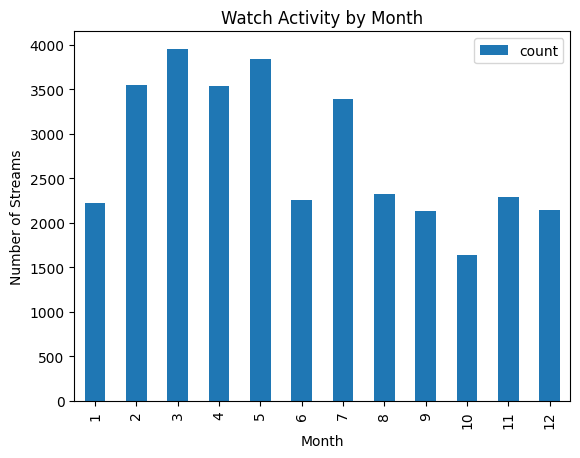

In [14]:
# Use Matplotlib to plot the all-time streams by month
monthly_df.plot(kind="bar", x="month", y="count")
plt.title("Watch Activity by Month")
plt.xlabel("Month")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    monthly_df,
    x="month",
    y="count",
    title="Watch Activity by Month",
    labels={"month": "Month", "count": "Number of Streams"}
)

fig.show()

In [15]:
# Returns the number of streams per month and year
cleaned_df_copy["month_year"] = cleaned_df_copy["time"].dt.to_period("M").astype(str) # Creates a new column for month and year
month_year_counts = cleaned_df_copy["month_year"].value_counts().sort_index() # Counts the number of streams per month and year
month_year_df = month_year_counts.reset_index()
month_year_df.head(10)

,month_year,count
0,2021-12,164
1,2022-01,284
2,2022-02,341
3,2022-03,99
4,2022-04,167
5,2022-05,519
6,2022-06,403
7,2022-07,274
8,2022-08,516
9,2022-09,584


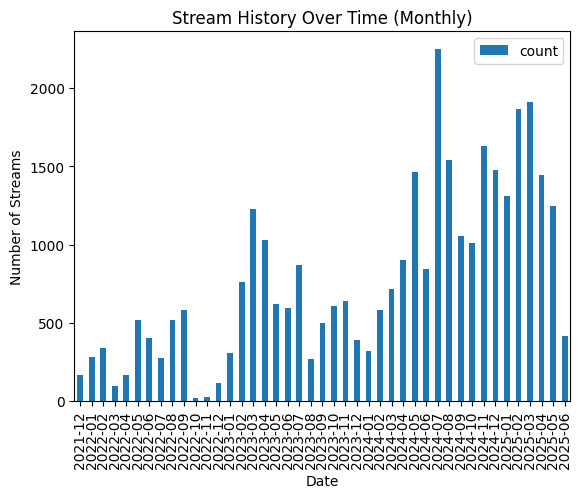

In [16]:
# Use Matplotlib to plot the all-time streams by month and year
month_year_df.plot(kind="bar", x="month_year", y="count")
plt.title("Stream History Over Time (Monthly)")
plt.xlabel("Date")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    month_year_df,
    x="month_year",
    y="count",
    title="Stream History Over Time (Monthly)",
    labels={"month_year" : "Date", "count" : "Number of Streams"}
)

fig.show()

In [17]:
# Returns the number of streams per hour
cleaned_df_copy["hour"] = cleaned_df_copy["time"].dt.hour
hourly_counts = cleaned_df_copy["hour"].value_counts().sort_index() # Counts the number of streams per hour
hourly_df = hourly_counts.reset_index()
hourly_df.head()

,hour,count
0,0,162
1,1,38
2,2,9
3,3,5
4,4,15


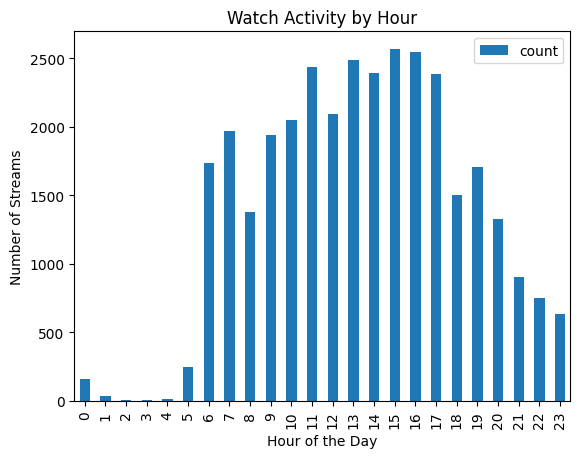

In [18]:
# Use Matplotlib to plot the all-time streams by hour
hourly_df.plot(kind="bar", x="hour", y="count")
plt.title("Watch Activity by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive bar chart
fig = px.bar(
    hourly_df,
    x="hour",
    y="count",
    title="Watch Activity by Hour",
    labels={"hour" : "Hour of Day", "count" : "Number of Streams"}
)
fig.show()

In [19]:
# Returns the number of streams per week
cleaned_df_copy["week"] = cleaned_df_copy["time"].dt.to_period("W").apply(lambda x: x.start_time) # Creates a new column for week starting date
weekly_counts = cleaned_df_copy["week"].value_counts().sort_index() # Counts the number of streams per week
weekly_df = weekly_counts.reset_index()
weekly_df.head()

,week,count
0,2021-12-13,128
1,2021-12-20,23
2,2021-12-27,13
3,2022-01-03,23
4,2022-01-10,124


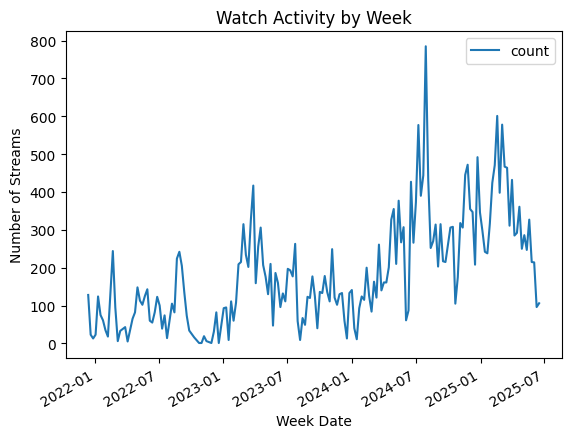

In [20]:
# Use Matplotlib to plot the all-time streams by week
weekly_df.plot(kind="line", x="week", y="count")
plt.title("Watch Activity by Week")
plt.xlabel("Week Date")
plt.ylabel("Number of Streams")
plt.show()

# Or using Plotly for an interactive line chart
fig = px.line(
    weekly_df,
    x="week",
    y="count",
    title="Watch Activity by Week",
    labels={"week" : "Week Date", "count" : "Number of Streams"},
    markers=True
)
fig.show()

In [21]:
# Creates a SQLite database and saves the cleaned DataFrame and the streamed artists, music, and albums to it
engine = create_engine("sqlite:///data/streaming_history.db") # Creates a SQLite database
cleaned_df.to_sql("streaming_history", con=engine, if_exists="replace", index=False) # Saves the cleaned DataFrame to the database
streamed_artists.to_sql("streamed_artists", con=engine, if_exists="replace", index=False) # Saves the streamed artists to the database
streamed_music.to_sql("streamed_music", con=engine, if_exists="replace", index=False) # Saves the streamed music to the database
streamed_albums.to_sql("streamed_albums", con=engine, if_exists="replace", index=False) # Saves the streamed albums to the database

2583

In [22]:
# Sample query to fetch data from the SQLite database
conn = sqlite3.connect("data/streaming_history.db") # Connects to the SQLite database
cursor = conn.cursor()

cursor.execute("""
    SELECT * 
    FROM streaming_history
    WHERE artist = "Cup of Joe"
    LIMIT 10;
""")
rows = cursor.fetchall() # Fetches the results of the query
for row in rows:
    print(row) # Prints each row of the results

conn.close() # Closes the database connection

(4394, '2023-02-26 09:07:32.000000', 'Estranghero', 'Cup of Joe', 'Estranghero', 'fwdbtn', 'trackdone', 0)
(4396, '2023-02-26 09:10:42.000000', 'Estranghero', 'Cup of Joe', 'Estranghero', 'clickrow', 'trackdone', 0)
(4397, '2023-02-26 09:15:28.000000', 'Ikaw Pa Rin Ang Pipiliin Ko', 'Cup of Joe', 'Ikaw Pa Rin Ang Pipiliin Ko', 'trackdone', 'endplay', 1)
(4398, '2023-02-26 09:15:29.000000', 'Estranghero', 'Cup of Joe', 'Estranghero', 'clickrow', 'endplay', 1)
(4399, '2023-02-26 09:18:36.000000', 'Estranghero', 'Cup of Joe', 'Estranghero', 'clickrow', 'trackdone', 0)
(4400, '2023-02-26 09:20:20.000000', 'Ikaw Pa Rin Ang Pipiliin Ko', 'Cup of Joe', 'Ikaw Pa Rin Ang Pipiliin Ko', 'trackdone', 'endplay', 1)
(4401, '2023-02-26 09:28:16.000000', 'Estranghero', 'Cup of Joe', 'Estranghero', 'clickrow', 'trackdone', 0)
(4402, '2023-02-26 09:32:38.000000', 'Ikaw Pa Rin Ang Pipiliin Ko', 'Cup of Joe', 'Ikaw Pa Rin Ang Pipiliin Ko', 'trackdone', 'trackdone', 0)
(4403, '2023-02-26 09:35:32.000000', 